In [1]:
import os
import pathlib
import trimesh
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
base_dir = pathlib.Path("../../dataset/extracted/scene_04")
mesh_f = base_dir / "mesh.ply"
rgb_dir = base_dir / "rgb"
depth_dir = base_dir / "depth"
mat_dir = base_dir / "mat"

In [3]:
frame_idx = 0
rgb_f = rgb_dir / f"{frame_idx:05d}.png"
depth_f = depth_dir / f"{frame_idx:05d}.npz"
mat_f = mat_dir / f"{frame_idx:05d}.npz"

In [4]:
rgb = np.array(Image.open(rgb_f))
depth = np.load(depth_f)["depth"]
K = np.load(mat_f)["K"]
w2c = np.load(mat_f)["w2c"]

In [5]:
K.shape, w2c.shape

((3, 3), (4, 4))

In [6]:
mesh = trimesh.load(mesh_f, process=False)
verts = np.array(mesh.vertices)
n_verts = verts.shape[0]

In [7]:
homo_coords = np.concatenate((verts, np.ones((n_verts, 1))), axis=1)  # [N, 4]
cam_coords = np.matmul(w2c, homo_coords.T).T
cam_coords = cam_coords[:, :3] / cam_coords[:, 3:]

In [8]:
pix_coords = np.matmul(K, cam_coords.T).T
pix_coords = pix_coords[:, :2] / pix_coords[:, 2:]

# filter points that are out of view
h, w, _ = rgb.shape
flag = (
    (pix_coords[:, 0] >= 0) &
    (pix_coords[:, 0] < w) &
    (pix_coords[:, 1] >= 0) &
    (pix_coords[:, 1] < h)
)
filtered_pix_coords = pix_coords[flag, :]

(0.0, 960.0)

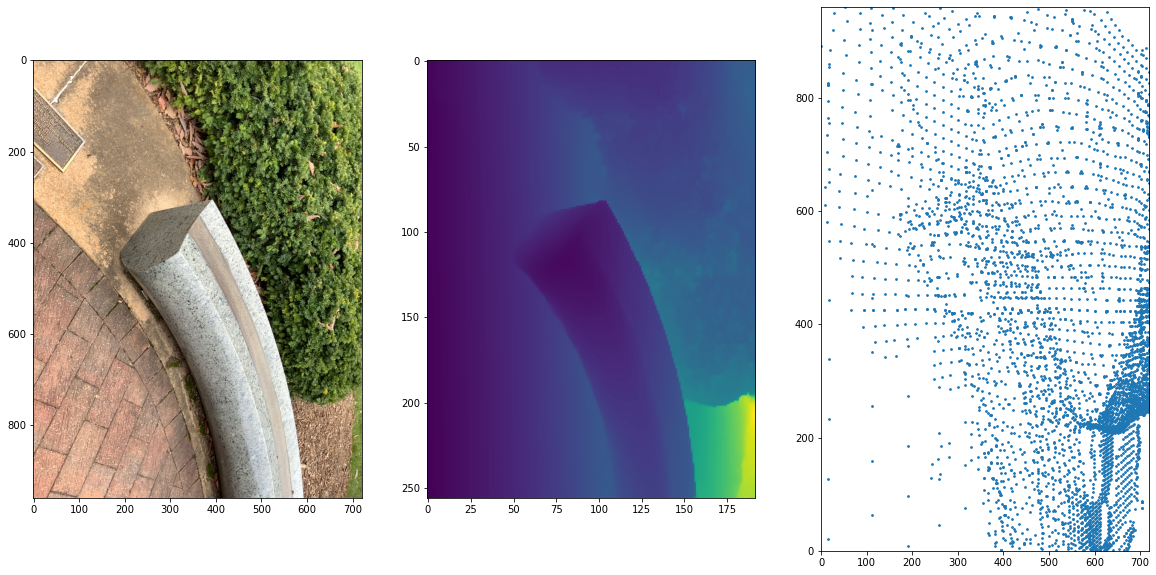

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
grid = plt.GridSpec(1, 3, figure=fig)

plt.subplot(grid[0, 0]).imshow(rgb)

plt.subplot(grid[0, 1]).imshow(depth)

ax = plt.subplot(grid[0, 2])
ax.scatter(filtered_pix_coords[:, 0], h - filtered_pix_coords[:, 1], s=3)
ax.set_xlim([0, w])
ax.set_ylim([0, h])